In [ ]:
!pip install wandb

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m013 (ma23m013-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Question-1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


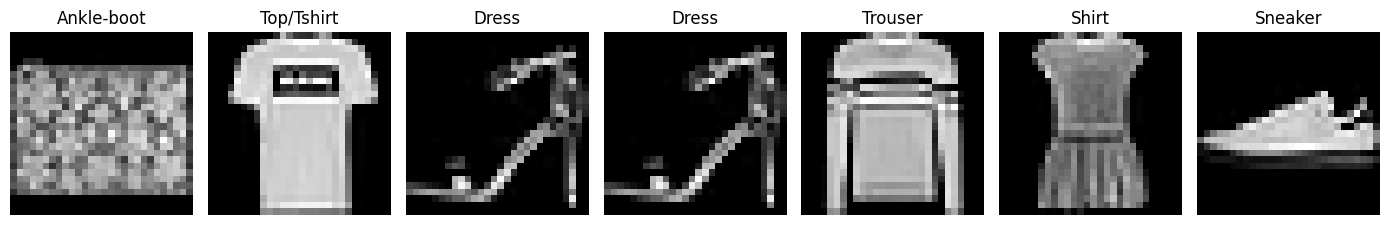

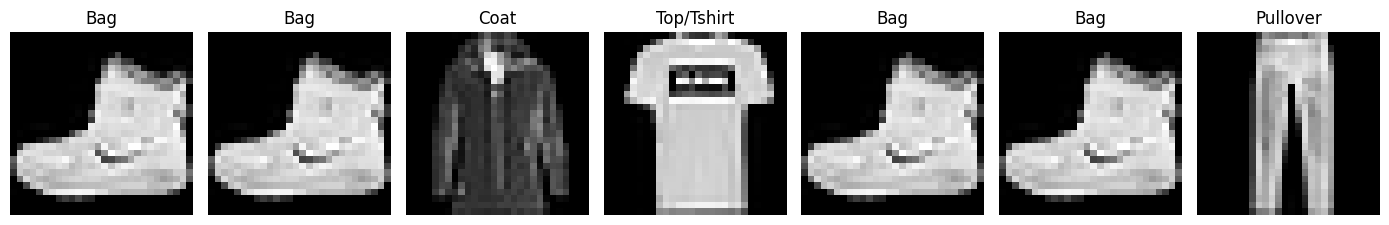

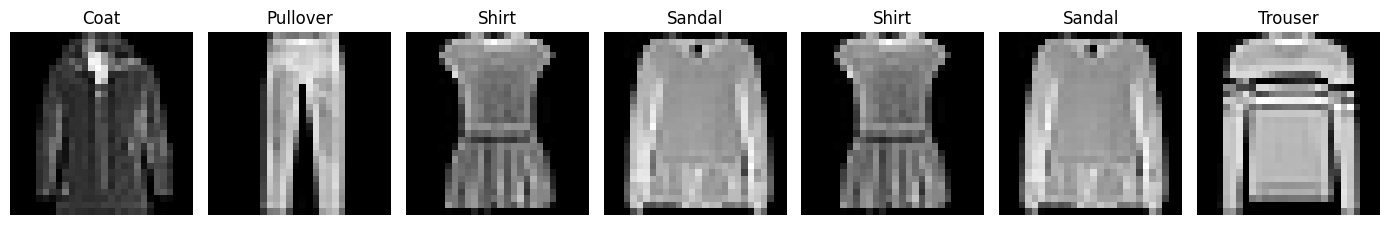

In [ ]:
# Initialize WandB project
wandb.init(project='DA6401_Assignment-1')

# Load Fashion-MNIST dataset (train and test sets)
(train_img, train_lbl), (test_img, test_lbl) = fashion_mnist.load_data()

# Define class names for labels
class_names = ['Top/Tshirt', 'Pullover', 'Trouser', 'Shirt', 'Coat', 'Dress', 'Sandal', 'Sneaker', 'Ankle-boot', 'Bag']

# Select one sample image for each class
samples = {}
for i in range(100):  # Loop through first 36 images
  lbl = train_lbl[i]  # Get label of current image
  if lbl not in samples:  # If label is not already added, add it
    samples[lbl] = train_img[i]
  if len(samples) == 10:  # Stop when all 10 classes have at least one image
    break

# Convert dictionary to lists for easy indexing
sample_lbl = list(samples.keys())
sample_img = list(samples.values())

# Function to plot 7 random sample images
def plot_sample(step):
  fig, axes = plt.subplots(1, 7, figsize=(14, 5))  # Create figure with 7 subplots
  chosen_indices = np.random.choice(len(sample_img), 7, replace=True)  # Randomly select 7 images

  for ax, idx in zip(axes.flatten(), chosen_indices):
    ax.imshow(sample_img[idx], cmap='gray')  # Display image
    ax.set_title(class_names[sample_lbl[idx]])  # Set title with class name
    ax.axis('off')  # Remove axis for cleaner view

  plt.tight_layout()
  plt.show()
  return fig

# Log images to WandB for visualization
wandb.log({"Examples": [wandb.Image(plot_sample(0), caption="Step 0"),
    wandb.Image(plot_sample(1), caption="Step 1"), wandb.Image(plot_sample(2), caption="Step 2")]})

# Finish WandB run
wandb.finish()


## Question-2

In [ ]:

# Activation function (Sigmoid)
def act(x):
  return 1/(1+np.exp(-x))  # Converts input into a range between 0 and 1

# Derivative of Sigmoid, used in backpropagation to compute gradients
def act_der(x):
  return act(x)*(1-act(x))

# Softmax function, converts output layer activations into probabilities
def soft_func(x):
  x = x-np.max(x) # Normalize values to prevent overflow
  return np.exp(x)/np.sum(np.exp(x), axis=0)

# Initialize neural network weights and biases
def initnet(n_layers, nodes, init_m, inp_dim, out_dim):
  """
    Initializes the neural network weights and biases.

    Parameters:
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - init_m: Weight initialization method ('rand' or 'xav')
    - inp_dim: Input dimension
    - out_dim: Output dimension

    Returns:
    - Dictionary containing initialized weights and biases
    """
  net_size = []
  for i in range(n_layers):
    net_size.append(nodes)

  size = [inp_dim]+net_size+[out_dim]  # Define the structure of the network
  wts = {}  # Dictionary to store weights and biases

  if init_m == 'rand': # Random weight initialization
    for i in range(1, n_layers+2):
      wts['W'+str(i)] = np.random.randn(size[i],size[i-1])
      wts['b'+str(i)] = np.random.randn(size[i],1)
  elif init_m == 'xav': # Xavier initialization for better weight scaling
    for i in range(1, n_layers+2):
      wts['W'+str(i)] = np.random.randn(size[i],size[i-1])*(np.sqrt(2/size[i-1]))
      wts['b'+str(i)] = np.random.randn(size[i],1)*(np.sqrt(2/size[i-1]))

  return wts

# Forward propagation - calculates activations layer by layer
def forwprop(inp,wts, n_layers, inp_dim):
  """
    Performs forward propagation.

    Parameters:
    - inp: Input data
    - wts: Weights dictionary
    - n_layers: Number of hidden layers
    - inp_dim: Input dimension

    Returns:
    - acts: Dictionary storing activations
    - out: Dictionary storing outputs at each layer
    - pred: Output probabilities from the softmax layer
    """
  acts = {} # Store activation values
  acts['a0'] = np.zeros((inp_dim,1)) # Initialize first activation
  out = {'h0':inp} # Store input layer values

  for i in range(1,n_layers+1): # Iterate through hidden layers
    acts['a'+str(i)]= np.dot(wts['W'+str(i)], out['h'+str(i-1)]) + wts['b'+str(i)]
    out['h'+str(i)]= act(acts['a'+str(i)]) # Apply activation function
  # Output layer processing
  acts['a'+str(n_layers+1)]= np.dot(wts['W'+str(n_layers+1)], out['h'+str(n_layers)]) + wts['b'+str(n_layers+1)]
  pred = soft_func(acts['a'+str(n_layers+1)]) # Apply softmax for probabilities

  return acts, out, pred

# Backpropagation - calculates gradients for weight updates
def backprop(inp, true_lbl, n_layers, wts, inp_dim):
  """
    Performs backpropagation to compute gradients.

    Parameters:
    - inp: Input data
    - true_lbl: True labels
    - n_layers: Number of hidden layers
    - wts: Weights dictionary
    - inp_dim: Input dimension

    Returns:
    - grad: Dictionary containing gradients for weight and bias updates
    """
  m = inp.shape[0] # Number of examples
  acts, out, pred = forwprop(inp, wts, n_layers, inp_dim)
  grad = {} # Store gradients
  err = {} # Store error terms
  err['a'+str(n_layers+1)] = -1*(true_lbl.T-pred) # Compute error for output layer

  for i in range(n_layers+1,0,-1): # Iterate backwards through layers
    grad['W'+str(i)]= (1/m)*np.dot(err['a'+str(i)], out['h'+str(i-1)].T) # Compute weight gradient
    grad['b'+str(i)]= (1/m)*np.mean(err['a'+str(i)], axis=1, keepdims=True) # Compute bias gradient
    if i>1:
      err['h'+str(i-1)]= np.dot(wts['W'+str(i)].T, err['a'+str(i)]) # Propagate error backward
      err['a'+str(i-1)]= err['h'+str(i-1)]*act_der(acts['a'+str(i-1)]) # Apply derivative of activation
  return grad

# Gradient Descent with loss tracking
def upd_wts(lr, wts, inp, true_lbl, n_layers, inp_dim):
  wandb.init(project='DA6401_Assignment-1', name='GradientDescent')
  losses= []  # Store losses for each epoch
  for e in range(100): # Train for 100 epochs
    grad = backprop(inp, true_lbl, n_layers, wts, inp_dim)
    for i in range (1, n_layers+2):
      wts['W'+str(i)] -= lr*grad['W'+str(i)] # Update weights
      wts['b'+str(i)] -= lr*grad['b'+str(i)] # Update biases

    # Compute loss for this epoch
    acts, out, pred = forwprop(inp, wts, n_layers, inp_dim)
    loss = -np.mean(np.sum(true_lbl.T*np.log(pred),axis=0))
    losses.append(loss)
    wandb.log({'Epoch': e+1, 'Loss': loss})
    print(f'Epoch {e+1}, Loss: {loss}')

  # Plot the loss function over epochs
  plt.plot(losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.show()

  wandb.finish()
  return wts, losses

# Compute accuracy of the model
def cal_acc(test_inp, test_lbl, wts, n_layers, inp_dim):
  acts, out, pred = forwprop(test_inp, wts, n_layers, inp_dim)
  assert test_lbl.shape == pred.shape # Ensure shapes match
  test_lbl = np.argmax(test_lbl, axis=0) # Convert one-hot labels to index
  pred = np.argmax(pred, axis=0) # Get predicted class
  correct = np.sum(test_lbl==pred) # Count correct predictions
  acc = correct/test_lbl.shape[0] # Compute accuracy

  wandb.log({'Test Accuracy': acc})
  return acc


## Question-3

In [29]:

# Activation functions
def sigmoid(x):
    """Compute the sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def relu(x):
    """Compute the ReLU activation function."""
    return np.maximum(0, x)

def tanh(x):
    """Compute the tanh activation function."""
    return np.tanh(x)

# Derivatives of activation functions
def sigmoid_derivative(x):
    """Compute the derivative of the sigmoid function."""
    return sigmoid(x) * (1 - sigmoid(x))

def relu_derivative(x):
    """Compute the derivative of the ReLU function."""
    return np.where(x <= 0, 0, 1)

def tanh_derivative(x):
    """Compute the derivative of the tanh function."""
    return 1 - tanh(x)**2

# Softmax function for multi-class classification
def softmax(x):
    """Compute the softmax function to convert logits into probabilities."""
    x = x - np.max(x)  # Normalize to prevent numerical instability
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# Function to apply the chosen activation function
def activation_function(x, func_type):
    """Return the output of the specified activation function."""
    if func_type == 'sigmoid':
        return sigmoid(x)
    elif func_type == 'relu':
        return relu(x)
    else:
        return tanh(x)

# Function to apply the corresponding activation derivative
def activation_derivative(x, func_type):
    """Return the derivative of the specified activation function."""
    if func_type == 'sigmoid':
        return sigmoid_derivative(x)
    elif func_type == 'relu':
        return relu_derivative(x)
    else:
        return tanh_derivative(x)

# Initialize network weights and biases
def initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim):
    """
    Initialize the network parameters (weights and biases) using the specified initialization method.

    Args:
        num_layers (int): Number of hidden layers.
        num_neurons (int): Number of neurons in each hidden layer.
        weight_init (str): Weight initialization method ('random' or 'xavier').
        input_dim (int): Number of input features.
        output_dim (int): Number of output classes.

    Returns:
        dict: Dictionary containing initialized weights and biases.
    """
    layer_sizes = [input_dim] + [num_neurons] * num_layers + [output_dim]  # Define layer sizes
    parameters = {}

    if weight_init == 'random':
        # Initialize weights and biases randomly
        for i in range(1, num_layers + 2):
            parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1])
            parameters[f'b{i}'] = np.random.randn(layer_sizes[i], 1)
    elif weight_init == 'xavier':
        # Initialize weights using Xavier initialization
        for i in range(1, num_layers + 2):
            parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(2 / layer_sizes[i-1])
            parameters[f'b{i}'] = np.random.randn(layer_sizes[i], 1) * np.sqrt(2 / layer_sizes[i-1])

    return parameters

# Compute cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    """
    Compute the cross-entropy loss for multi-class classification.

    Args:
        y_true (numpy array): One-hot encoded true labels.
        y_pred (numpy array): Predicted probability distribution.

    Returns:
        float: Cross-entropy loss.
    """
    epsilon = 1e-15  # Prevents log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Avoid numerical issues
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=0))

# Forward propagation
def forward_propagation(inputs, params, activation, num_layers, input_dim):
    """
    Perform forward propagation through the neural network.

    Args:
        inputs (numpy array): Input data.
        params (dict): Dictionary containing weights and biases.
        activation (str): Activation function to use.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.

    Returns:
        tuple: Activations, layer outputs, and final predictions.
    """
    activations, layer_outputs = {}, {}
    activations['a0'] = np.zeros((input_dim, 1))  # Initialize first activation (not used)
    layer_outputs['h0'] = inputs  # Input layer

    # Forward propagate through hidden layers
    for i in range(1, num_layers + 1):
        activations[f'a{i}'] = np.dot(params[f'W{i}'], layer_outputs[f'h{i-1}']) + params[f'b{i}']
        layer_outputs[f'h{i}'] = activation_function(activations[f'a{i}'], activation)

    # Compute final layer output (softmax for multi-class classification)
    activations[f'a{num_layers+1}'] = np.dot(params[f'W{num_layers+1}'], layer_outputs[f'h{num_layers}']) + params[f'b{num_layers+1}']
    predictions = softmax(activations[f'a{num_layers+1}'])

    return activations, layer_outputs, predictions

# Backward propagation
def backward_propagation(inputs, labels, activation, num_layers, params, input_dim):
    """
    Perform backward propagation to compute gradients for weight and bias updates.

    Args:
        inputs (numpy array): Input data.
        labels (numpy array): True labels in one-hot encoding.
        activation (str): Activation function used in hidden layers.
        num_layers (int): Number of hidden layers.
        params (dict): Dictionary containing weights and biases.
        input_dim (int): Number of input features.

    Returns:
        dict: Gradients of weights and biases.
    """
    activations, layer_outputs, predictions = forward_propagation(inputs, params, activation, num_layers, input_dim)
    gradients, backprops = {}, {}

    # Compute loss gradient w.r.t final layer activation
    backprops[f'a{num_layers+1}'] = -1 * (labels - predictions)

    # Backpropagate through layers
    for i in range(num_layers + 1, 0, -1):
        gradients[f'W{i}'] = np.dot(backprops[f'a{i}'], layer_outputs[f'h{i-1}'].T)
        gradients[f'b{i}'] = backprops[f'a{i}']
        backprops[f'h{i-1}'] = np.dot(params[f'W{i}'].T, backprops[f'a{i}'])
        backprops[f'a{i-1}'] = backprops[f'h{i-1}'] * activation_derivative(activations[f'a{i-1}'], activation)

    return gradients

# Compute accuracy on test data
def compute_accuracy(X_test, Y_test, trained_params, activation, num_layers, input_dim):
    """
    Compute classification accuracy on test data.

    Args:
        X_test (numpy array): Test data.
        Y_test (numpy array): True labels in one-hot encoding.
        trained_params (dict): Trained weights and biases.
        activation (str): Activation function used in hidden layers.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.

    Returns:
        float: Accuracy of the model on test data.
    """
    num_samples = X_test.shape[0]
    correct = 0

    # Iterate over all test samples
    for i in range(num_samples):
        input_sample = X_test[i, :].reshape(-1, 1)
        _, _, pred = forward_propagation(input_sample, trained_params, activation, num_layers, input_dim)

        # Check if predicted class matches true label
        if np.argmax(Y_test[i, :].reshape(-1, 1)) == np.argmax(pred):
            correct += 1

    return correct / num_samples  # Return accuracy as a fraction



Stochastic Gradient Descent

In [30]:
def stochastic_gd(learning_rate, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_layers, num_neurons, weight_init, batch_size, input_dim, output_dim):
    """
    Perform stochastic gradient descent (SGD) to train a neural network.

    Args:
        learning_rate (float): Learning rate for weight updates.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        epochs (int): Number of training epochs.
        activation (str): Activation function used in hidden layers.
        num_layers (int): Number of hidden layers.
        num_neurons (int): Number of neurons per hidden layer.
        weight_init (str): Weight initialization method ('random' or 'xavier').
        batch_size (int): Number of samples per batch update.
        input_dim (int): Number of input features.
        output_dim (int): Number of output classes.

    Returns:
        dict: Trained network parameters (weights and biases).
    """
    # Initialize the neural network parameters (weights and biases)
    params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)

    # List to store loss values over epochs for visualization
    losses = []

    # Get the number of training samples
    num_samples = X_train.shape[0]

    for epoch in range(epochs):  # Loop over the number of epochs
        indices = np.arange(num_samples)  # Create an array of sample indices
        np.random.shuffle(indices)  # Shuffle the indices for stochastic updates

        # Dictionary to accumulate gradients for batch updates
        batch_updates = {key: np.zeros_like(value) for key, value in params.items()}

        for idx in range(num_samples):  # Loop over each training sample
            # Select one sample and reshape it into a column vector
            input_sample = X_train[indices[idx], :].reshape(-1, 1)
            label_sample = Y_train[indices[idx], :].reshape(-1, 1)

            # Perform backward propagation to compute gradients
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim)

            # Accumulate gradients for batch update
            for k in range(1, num_layers + 2):
                batch_updates[f'W{k}'] += gradients[f'W{k}']
                batch_updates[f'b{k}'] += gradients[f'b{k}']

            # Perform parameter update after processing 'batch_size' samples
            if (idx + 1) % batch_size == 0:
                for i in range(1, num_layers + 2):
                    params[f'W{i}'] -= learning_rate * batch_updates[f'W{i}']
                    params[f'b{i}'] -= learning_rate * batch_updates[f'b{i}']

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        _, _, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        _, _, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': train_acc * 100,
                   'val_loss': val_loss,
                   'val_accuracy': val_acc * 100,
                   'epoch': epoch})

    # Plot training loss over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

    return params  # Return the trained network parameters


Momentum Based Gradient Descent

In [31]:
def momentum_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta=0.9):
    """
    Implements the Momentum Optimizer for training a neural network.
        u_t = β * u_(t-1) + ∇w_t
        w_(t+1) = w_t - η * u_t

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        beta (float, optional): Momentum coefficient (default: 0.9).

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store the training loss over epochs
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize velocity for momentum updates (same shape as parameters)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_velocity = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        num_processed = 0  # Counter for processed samples
        epoch_loss = 0  # Initialize loss for the current epoch
        num_batches = 0  # Count number of batches processed
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}  # Accumulate gradients

        for sample_idx in range(num_samples):  # Loop through all training samples
            num_processed += 1  # Increment processed sample counter

            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator['W' + str(layer)] += gradients['W' + str(layer)]
                gradient_accumulator['b' + str(layer)] += gradients['b' + str(layer)]

            # Update weights and biases once the batch is complete
            if num_processed % batch_size == 0:
                num_batches += 1  # Increment batch count

                for layer in range(1, num_layers + 2):
                    # Compute velocity update using momentum
                    velocity['W' + str(layer)] = beta * prev_velocity['W' + str(layer)] + gradient_accumulator['W' + str(layer)]
                    velocity['b' + str(layer)] = beta * prev_velocity['b' + str(layer)] + gradient_accumulator['b' + str(layer)]


                    # Apply momentum-based update to parameters
                    params['W' + str(layer)] -= learning_rate * velocity['W' + str(layer)]
                    params['b' + str(layer)] -= learning_rate * velocity['b' + str(layer)]

                # Store previous velocity values for the next batch update
                    prev_velocity['W' + str(layer)] = velocity['W' + str(layer)]
                    prev_velocity['b' + str(layer)] = velocity['b' + str(layer)]

        # Compute training accuracy at the end of the epoch
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        _, _, train_predictions = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_predictions)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        _, _, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': train_acc * 100,
                   'val_loss': val_loss,
                   'val_accuracy': val_acc * 100,
                   'epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


Nesterov Accelerated Gradient Descent

In [32]:
def nag_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta=0.9):
    """
    Implements Nesterov Accelerated Gradient (NAG) optimizer for training a neural network.
        u_t = β * u_(t-1) + ∇(w - η*β * u_(t-1))
        w_(t+1) = w_t - η * u_t

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        beta (float, optional): Momentum coefficient (default: 0.9).

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store training loss for each epoch
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize velocity for momentum updates (same shape as parameters)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_velocity = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}  # Accumulate gradients
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize loss for current epoch

        for sample_idx in range(num_samples):  # Iterate over all training samples
            num_processed += 1  # Increment processed sample counter

            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Look ahead by applying momentum before computing gradients
            for layer in range(1, num_layers + 2):
                params['W' + str(layer)] -= learning_rate * beta * prev_velocity['W' + str(layer)]
                params['b' + str(layer)] -= learning_rate * beta * prev_velocity['b' + str(layer)]

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator['W' + str(layer)] += gradients['W' + str(layer)]
                gradient_accumulator['b' + str(layer)] += gradients['b' + str(layer)]

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                num_batches += 1  # Increment batch count

                for layer in range(1, num_layers + 2):
                    # Compute velocity update using Nesterov's momentum
                    velocity['W' + str(layer)] = beta * prev_velocity['W' + str(layer)] + gradient_accumulator['W' + str(layer)]
                    velocity['b' + str(layer)] = beta * prev_velocity['b' + str(layer)] + gradient_accumulator['b' + str(layer)]


                    # Apply velocity-based update to parameters
                    params['W' + str(layer)] -= learning_rate * velocity['W' + str(layer)]
                    params['b' + str(layer)] -= learning_rate * velocity['b' + str(layer)]

                # Store previous velocity values for the next batch update
                    prev_velocity['W' + str(layer)] = velocity['W' + str(layer)]
                    prev_velocity['b' + str(layer)] = velocity['b' + str(layer)]

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        _, _, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        _, _, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': train_acc * 100,
                   'val_loss': val_loss,
                   'val_accuracy': val_acc * 100,
                   'epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


RMSPROP

In [33]:
def rmsprop_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon=0.01, beta=0.9):
    """
    Implements the RMSprop (Root Mean Square Propagation) optimizer for training a neural network.
        v_t = β * v_(t-1) + (1-β) * (∇w_t)^2
        w_(t+1) = w_t - η*(∇w_t / (√v_t + ε))

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        epsilon (float, optional): Small constant to avoid division by zero (default: 0.01).
        beta (float, optional): Decay rate for the moving average of squared gradients (default: 0.9).

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store training loss for each epoch
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize velocity (moving average of squared gradients) for each parameter
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_velocity = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate through epochs
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize loss for the current epoch

        # Initialize gradient accumulator for batch updates
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):  # Iterate through all training samples
            num_processed += 1  # Increment processed sample counter

            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator['W' + str(layer)] += gradients['W' + str(layer)]
                gradient_accumulator['b' + str(layer)] += gradients['b' + str(layer)]

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                num_batches += 1  # Increment batch count

                for layer in range(1, num_layers + 2):
                    # Compute moving average of squared gradients (RMSprop update)
                    velocity['W' + str(layer)] = beta * prev_velocity['W' + str(layer)] + (1 - beta) * (gradient_accumulator['W' + str(layer)] ** 2)
                    velocity['b' + str(layer)] = beta * prev_velocity['b' + str(layer)] + (1 - beta) * (gradient_accumulator['b' + str(layer)] ** 2)


                    # Apply RMSprop update rule to parameters
                    params['W' + str(layer)] -= (learning_rate / (np.sqrt(velocity['W' + str(layer)] + epsilon))) * gradient_accumulator['W' + str(layer)]
                    params['b' + str(layer)] -= (learning_rate / (np.sqrt(velocity['b' + str(layer)] + epsilon))) * gradient_accumulator['b' + str(layer)]

                # Store previous velocity values for the next batch update
                    prev_velocity['W' + str(layer)] = velocity['W' + str(layer)]
                    prev_velocity['b' + str(layer)] = velocity['b' + str(layer)]

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        _, _, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        _, _, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': train_acc * 100,
                   'val_loss': val_loss,
                   'val_accuracy': val_acc * 100,
                   'epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


ADAM

In [34]:
def adam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1=0.9, beta2=0.99):
    """
    Implements the Adam (Adaptive Moment Estimation) optimizer for training a neural network.
        m_t = β1*m_(t-1) + (1-β1)*∇w_t
        hat{m_t} = m_t / (1-β1^t)
        v_t = β2*v_(t-1) + (1-β2)*(∇w_t)^2
        hat{v_t} = v_t / (1-β2^t)
        w_(t+1) = w_t - η*(hat{m_t} / (√(hat{v_t}) +ε) )

    Args:
        learning_rate (float): Learning rate for parameter updates.
        params (dict): Dictionary containing neural network weights and biases.
        X_train (numpy array): Training input data.
        Y_train (numpy array): One-hot encoded training labels.
        X_valid (numpy array): Validation input data.
        Y_valid (numpy array): One-hot encoded validation labels.
        activation (str): Activation function used in hidden layers.
        epochs (int): Number of training epochs.
        num_layers (int): Number of hidden layers.
        input_dim (int): Number of input features.
        batch_size (int): Number of samples per batch update.
        epsilon (float): Small constant to avoid division by zero.
        beta1 (float, optional): Exponential decay rate for first moment estimates (default: 0.9).
        beta2 (float, optional): Exponential decay rate for second moment estimates (default: 0.99).

    Returns:
        dict: Updated network parameters after training.
    """

    losses = []  # List to store loss values for each epoch
    num_samples = X_train.shape[0]  # Number of training samples

    # Initialize first moment vector (momentum)
    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_momentum = {key: np.zeros_like(value) for key, value in params.items()}
    momentum_corrected = {key: np.zeros_like(value) for key, value in params.items()}

    # Initialize second moment vector (velocity - moving average of squared gradients)
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_velocity = {key: np.zeros_like(value) for key, value in params.items()}
    velocity_corrected = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):  # Iterate over epochs
        time_step = 0  # Time step counter for bias correction
        num_processed = 0  # Counter for processed samples
        num_batches = 0  # Counter for number of batches
        epoch_loss = 0  # Initialize epoch loss

        # Initialize gradient accumulator for batch updates
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):  # Iterate through all training samples
            # Select a single training sample and reshape it into a column vector
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)

            # Compute gradients using backward propagation
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim)

            # Accumulate gradients for weight and bias updates
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator['W' + str(layer)] += gradients['W' + str(layer)]
                gradient_accumulator['b' + str(layer)] += gradients['b' + str(layer)]

            num_processed += 1  # Increment processed sample counter

            # Update weights and biases after processing a full batch
            if num_processed % batch_size == 0:
                time_step += 1  # Increment time step for bias correction
                num_batches += 1  # Increment batch count

                # Compute biased first moment estimate (momentum)
                for layer in range(1, num_layers + 2):
                    momentum['W' + str(layer)] = beta1 * prev_momentum['W' + str(layer)] + (1 - beta1) * gradient_accumulator['W' + str(layer)]
                    momentum['b' + str(layer)] = beta1 * prev_momentum['b' + str(layer)] + (1 - beta1) * gradient_accumulator['b' + str(layer)]

                # Compute bias-corrected first moment estimate
                    momentum_corrected['W' + str(layer)] = momentum['W' + str(layer)] / (1 - np.power(beta1, time_step))
                    momentum_corrected['b' + str(layer)] = momentum['b' + str(layer)] / (1 - np.power(beta1, time_step))

                    # Update previous momentum values
                    prev_momentum['W' + str(layer)] = momentum['W' + str(layer)]
                    prev_momentum['b' + str(layer)] = momentum['b' + str(layer)]

                # Compute biased second moment estimate (velocity)
                    velocity['W' + str(layer)] = beta2 * prev_velocity['W' + str(layer)] + (1 - beta2) * (gradient_accumulator['W' + str(layer)] ** 2)
                    velocity['b' + str(layer)] = beta2 * prev_velocity['b' + str(layer)] + (1 - beta2) * (gradient_accumulator['b' + str(layer)] ** 2)

                # Compute bias-corrected second moment estimate
                    velocity_corrected['W' + str(layer)] = velocity['W' + str(layer)] / (1 - np.power(beta2, time_step))
                    velocity_corrected['b' + str(layer)] = velocity['b' + str(layer)] / (1 - np.power(beta2, time_step))

                    # Update previous velocity values
                    prev_velocity['W' + str(layer)] = velocity['W' + str(layer)]
                    prev_velocity['b' + str(layer)] = velocity['b' + str(layer)]

                # Apply Adam update rule to parameters
                    params['W' + str(layer)] -= (learning_rate / (np.sqrt(velocity_corrected['W' + str(layer)] + epsilon))) * momentum_corrected['W' + str(layer)]
                    params['b' + str(layer)] -= (learning_rate / (np.sqrt(velocity_corrected['b' + str(layer)] + epsilon))) * momentum_corrected['b' + str(layer)]

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        _, _, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        _, _, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': train_acc * 100,
                   'val_loss': val_loss,
                   'val_accuracy': val_acc * 100,
                   'epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params  # Return the trained parameters


NADAM

In [35]:
def nadam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1=0.9, beta2=0.99):
    """
    Implements the Nadam (Nesterov-accelerated Adaptive Moment Estimation) optimization algorithm.

    Args:
        learning_rate: The step size for parameter updates.
        params: Dictionary containing the neural network parameters.
        X_train, Y_train: Training data and corresponding labels.
        X_valid, Y_valid: Validation data and corresponding labels.
        activation: Activation function used in the network.
        epochs: Number of training iterations.
        num_layers: Number of hidden layers.
        input_dim: Input dimension of the data.
        batch_size: Number of samples per batch update.
        epsilon: Small value to avoid division by zero.
        beta1: Decay rate for the first moment estimate (momentum term).
        beta2: Decay rate for the second moment estimate (velocity term).

    Returns:
        Updated parameters after training.
    """
    losses = []
    num_samples = X_train.shape[0]

    # Initialize velocity and momentum terms for all parameters
    velocity = {key: np.zeros_like(value) for key, value in params.items()}
    prev_velocity = {key: np.zeros_like(value) for key, value in params.items()}
    velocity_corrected = {key: np.zeros_like(value) for key, value in params.items()}

    momentum = {key: np.zeros_like(value) for key, value in params.items()}
    prev_momentum = {key: np.zeros_like(value) for key, value in params.items()}
    momentum_corrected = {key: np.zeros_like(value) for key, value in params.items()}

    for epoch in range(epochs):
        time_step = 0
        num_processed = 0
        num_batches = 0
        epoch_loss = 0
        gradient_accumulator = {key: np.zeros_like(value) for key, value in params.items()}

        for sample_idx in range(num_samples):
            # Forward pass for a single training sample
            input_sample = X_train[sample_idx, :].reshape(-1, 1)
            label_sample = Y_train[sample_idx, :].reshape(-1, 1)
            gradients = backward_propagation(input_sample, label_sample, activation, num_layers, params, input_dim)

            # Accumulate gradients over the batch
            for layer in range(num_layers + 1, 0, -1):
                gradient_accumulator['W' + str(layer)] += gradients['W' + str(layer)]
                gradient_accumulator['b' + str(layer)] += gradients['b' + str(layer)]

            num_processed += 1
            if num_processed % batch_size == 0:
                time_step += 1
                num_batches += 1

                # Compute momentum estimates
                for layer in range(1, num_layers + 2):
                    momentum['W' + str(layer)] = beta1 * prev_momentum['W' + str(layer)] + (1 - beta1) * gradient_accumulator['W' + str(layer)]
                    momentum['b' + str(layer)] = beta1 * prev_momentum['b' + str(layer)] + (1 - beta1) * gradient_accumulator['b' + str(layer)]

                # Bias-corrected momentum
                    momentum_corrected['W' + str(layer)] = momentum['W' + str(layer)] / (1 - np.power(beta1, time_step))
                    momentum_corrected['b' + str(layer)] = momentum['b' + str(layer)] / (1 - np.power(beta1, time_step))
                    prev_momentum['W' + str(layer)] = momentum['W' + str(layer)]
                    prev_momentum['b' + str(layer)] = momentum['b' + str(layer)]

                # Compute velocity estimates
                    velocity['W' + str(layer)] = beta2 * prev_velocity['W' + str(layer)] + (1 - beta2) * (gradient_accumulator['W' + str(layer)] ** 2)
                    velocity['b' + str(layer)] = beta2 * prev_velocity['b' + str(layer)] + (1 - beta2) * (gradient_accumulator['b' + str(layer)] ** 2)

                # Bias-corrected velocity
                    velocity_corrected['W' + str(layer)] = velocity['W' + str(layer)] / (1 - np.power(beta2, time_step))
                    velocity_corrected['b' + str(layer)] = velocity['b' + str(layer)] / (1 - np.power(beta2, time_step))
                    prev_velocity['W' + str(layer)] = velocity['W' + str(layer)]
                    prev_velocity['b' + str(layer)] = velocity['b' + str(layer)]

                # Update parameters using Nadam update rule
                    params['W'+str(layer)] -= (learning_rate/(np.sqrt(velocity_corrected['W'+str(layer)]) + epsilon)) * (beta1 * momentum_corrected['W'+str(layer)] + (1 - beta1) * gradient_accumulator['W'+str(layer)]/(1 - np.power(beta1, time_step)))
                    params['b'+str(layer)] -= (learning_rate/(np.sqrt(velocity_corrected['b'+str(layer)]) + epsilon)) * (beta1 * momentum_corrected['b'+str(layer)] + (1 - beta1) * gradient_accumulator['b'+str(layer)]/(1 - np.power(beta1, time_step)))

        # Compute training accuracy after epoch completion
        train_acc = compute_accuracy(X_train, Y_train, params, activation, num_layers, input_dim)

        # Compute training loss using cross-entropy
        _, _, train_preds = forward_propagation(X_train.T, params, activation, num_layers, input_dim)
        train_loss = cross_entropy_loss(Y_train.T, train_preds)
        losses.append(train_loss)  # Store loss for visualization

        # Compute validation accuracy
        val_acc = compute_accuracy(X_valid, Y_valid, params, activation, num_layers, input_dim)

        # Compute validation loss using cross-entropy
        _, _, val_preds = forward_propagation(X_valid.T, params, activation, num_layers, input_dim)
        val_loss = cross_entropy_loss(Y_valid.T, val_preds)


        # Print epoch summary
        print(f"Epoch {epoch+1}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc * 100:.2f}%, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc * 100:.2f}%")

        # Log results using Weights & Biases
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': train_acc * 100,
                   'val_loss': val_loss,
                   'val_accuracy': val_acc * 100,
                   'epoch': epoch})

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return params


## Question-4

In [36]:
# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Split the training data into training and validation sets (90% train, 10% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Flatten the images (convert 28x28 matrices into 1D arrays of size 784)
# Normalize pixel values to the range [0,1] by dividing by 255
X_train = X_train.reshape(X_train.shape[0], -1) / 255
X_valid = X_valid.reshape(X_valid.shape[0], -1) / 255
X_test = X_test.reshape(X_test.shape[0], -1) / 255

def one_hot_encod(arr):
    """
    Convert class labels to one-hot encoded vectors.

    Args:
        arr (numpy array): Array of class labels (e.g., [0, 1, 2, ..., 9])

    Returns:
        numpy array: One-hot encoded matrix of shape (len(arr), 10)
    """
    mat = np.zeros((len(arr), 10))  # Create a matrix of zeros with shape (num_samples, num_classes)
    for i in range(len(arr)):
        mat[i, arr[i]] = 1  # Set the corresponding class index to 1
    return mat

# Convert labels to one-hot encoding for training, validation, and test sets
Y_train = one_hot_encod(y_train)
Y_valid = one_hot_encod(y_valid)
Y_test = one_hot_encod(y_test)


In [37]:
def train_model(learning_rate, X_train, Y_train, X_valid, Y_valid, optimizer, regularization, epochs, activation, num_layers, num_neurons,
                weight_init, input_dim, output_dim, batch_size, epsilon, beta=0.9, beta1=0.9, beta2=0.99):
    """
    Train a neural network model using the specified optimizer.

    Parameters:
    - learning_rate: The learning rate for optimization.
    - X_train, Y_train: Training data and labels.
    - X_valid, Y_valid: Validation data and labels.
    - optimizer: The optimization algorithm to use ('sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam').
    - regularization: Regularization term (not currently used in this function).
    - epochs: Number of training epochs.
    - activation: Activation function to use.
    - num_layers: Number of hidden layers in the network.
    - num_neurons: Number of neurons in each hidden layer.
    - weight_init: Weight initialization method.
    - input_dim: Input feature dimension.
    - output_dim: Output dimension (number of classes for classification).
    - batch_size: Number of samples per training batch.
    - epsilon: Small constant to prevent division by zero.
    - beta, beta1, beta2: Hyperparameters for momentum-based optimizers.

    Returns:
    - params: The trained model parameters.
    """

    # Initialize the network with random weights based on the chosen weight initialization method
    params = initialize_network(num_layers, num_neurons, weight_init, input_dim, output_dim)

    # Select the appropriate optimizer and train the model
    if optimizer == 'sgd':
        # Stochastic Gradient Descent
        params = stochastic_gd(learning_rate, X_train, Y_train, X_valid, Y_valid, epochs, activation, num_layers, num_neurons, weight_init, batch_size, input_dim, output_dim)
    elif optimizer == 'momentum':
        # SGD with Momentum
        params = momentum_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta=0.9)
    elif optimizer == 'nesterov':
        # Nesterov Accelerated Gradient (NAG)
        params = nag_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, beta=0.9)
    elif optimizer == 'rmsprop':
        # RMSprop optimizer
        params = rmsprop_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon=0.01, beta=0.9)
    elif optimizer == 'adam':
        # Adam optimizer (Adaptive Moment Estimation)
        params = adam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1=0.9, beta2=0.99)
    elif optimizer == 'nadam':
        # Nadam optimizer (Adam with Nesterov momentum)
        params = nadam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1=0.9, beta2=0.99)

    return params


In [38]:
# Define the hyperparameter sweep configuration
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization for efficient hyperparameter tuning
    'name': 'sweep cross entropy now',  # Name of the sweep for tracking
    'metric': {'name': 'Val_accuracy',  # The metric to optimize
               'goal': 'maximize'},  # The objective is to maximize validation accuracy
    'parameters': {
        'epochs': {'values': [5, 10]},  # Number of training epochs
        'num_layers': {'values': [3, 4, 5]},  # Number of hidden layers
        'num_neurons': {'values': [32, 64, 128]},  # Neurons per layer
        'regularization': {'values': [0, 0.0005, 0.5]},  # L2 regularization strength
        'learning_rate': {'values': [1e-3, 1e-4]},  # Learning rate values
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},  # Optimizers to test
        'batch_size': {'values': [16, 32, 64]},  # Batch sizes for training
        'weight_init': {'values': ['random', 'xavier']},  # Weight initialization methods
        'activation': {'values': ['sigmoid', 'relu', 'tanh']}  # Activation functions to test
    }
}

# Initialize the sweep and get the sweep ID
sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_Assignment-1')
# Creates a new sweep in the project 'DA6401_Assignment-1' and returns a sweep ID


Create sweep with ID: 87ojm6jj
Sweep URL: https://wandb.ai/ma23m013-iit-madras/DA6401_Assignment-1/sweeps/87ojm6jj


wandb: Agent Starting Run: qj1xaz1p with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	regularization: 0.0005
wandb: 	weight_init: random


Epoch 9, Loss: 0.5412089571400704, Accuracy: 80.82777777777778


Traceback (most recent call last):
  File "<ipython-input-28-02e971811f88>", line 24, in main
    train_model(
  File "<ipython-input-24-c08ce9d49709>", line 48, in train_model
    params = nadam_optimizer(learning_rate, params, X_train, Y_train, X_valid, Y_valid, activation, epochs, num_layers, input_dim, batch_size, epsilon, beta1=0.9, beta2=0.99)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-22-6b5f72fec67d>", line 91, in nadam_optimizer
    wandb.log({'train_loss': epoch_loss})
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/lib/preinit.py", line 36, in preinit_wrapper
    raise wandb.Error(f"You must call wandb.init() before {name}()")
wandb.errors.errors.Error: You must call wandb.init() before wandb.log()


Epoch 1, Train_Loss: 31.0900, Train_Accuracy: 9.99%, Val_Loss: 31.0388, Val_Accuracy: 10.13%
Epoch 2, Train_Loss: 31.0830, Train_Accuracy: 10.01%, Val_Loss: 31.1022, Val_Accuracy: 9.95%
Epoch 3, Train_Loss: 31.1022, Train_Accuracy: 9.95%, Val_Loss: 30.9295, Val_Accuracy: 10.45%
Epoch 4, Train_Loss: 31.0919, Train_Accuracy: 9.98%, Val_Loss: 31.0216, Val_Accuracy: 10.18%
Epoch 5, Train_Loss: 31.0900, Train_Accuracy: 9.99%, Val_Loss: 31.0388, Val_Accuracy: 10.13%
Epoch 6, Train_Loss: 31.0900, Train_Accuracy: 9.99%, Val_Loss: 31.0388, Val_Accuracy: 10.13%
Epoch 7, Train_Loss: 31.0983, Train_Accuracy: 9.96%, Val_Loss: 30.9640, Val_Accuracy: 10.35%
Epoch 8, Train_Loss: 31.0971, Train_Accuracy: 9.96%, Val_Loss: 30.9755, Val_Accuracy: 10.32%
Epoch 9, Train_Loss: 31.0983, Train_Accuracy: 9.96%, Val_Loss: 30.9640, Val_Accuracy: 10.35%
Epoch 10, Train_Loss: 31.0983, Train_Accuracy: 9.96%, Val_Loss: 30.9640, Val_Accuracy: 10.35%


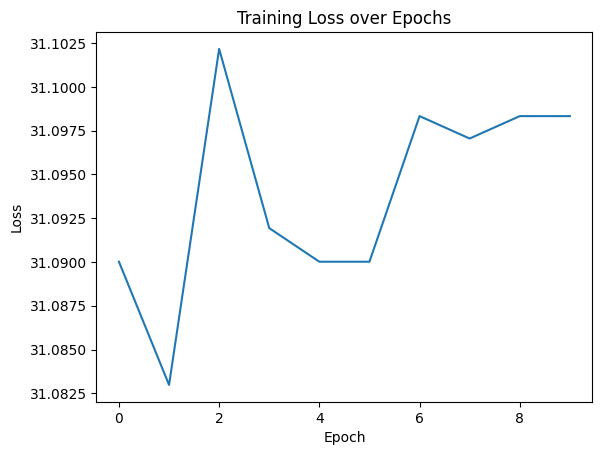

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▅█▁▅▅▅▂▃▂▂
train_loss,▄▁█▄▄▄▇▆▇▇
val_accuracy,▄▁█▄▄▄▇▆▇▇
val_loss,▅█▁▅▅▅▂▃▂▂
epoch,9
train_accuracy,9.96111
train_loss,31.09833
val_accuracy,10.35
val_loss,30.96401


wandb: Agent Starting Run: zhhesvft with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum
wandb: 	regularization: 0.5
wandb: 	weight_init: random


<ipython-input-29-5cfe7f9ee071>:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1, Train_Loss: 31.0830, Train_Accuracy: 10.01%, Val_Loss: 31.1022, Val_Accuracy: 9.95%
Epoch 2, Train_Loss: 31.0785, Train_Accuracy: 10.02%, Val_Loss: 31.1425, Val_Accuracy: 9.83%
Epoch 3, Train_Loss: 31.0529, Train_Accuracy: 10.09%, Val_Loss: 31.3727, Val_Accuracy: 9.17%
Epoch 4, Train_Loss: 31.0785, Train_Accuracy: 10.02%, Val_Loss: 31.1425, Val_Accuracy: 9.83%
Epoch 5, Train_Loss: 31.0785, Train_Accuracy: 10.02%, Val_Loss: 31.1425, Val_Accuracy: 9.83%


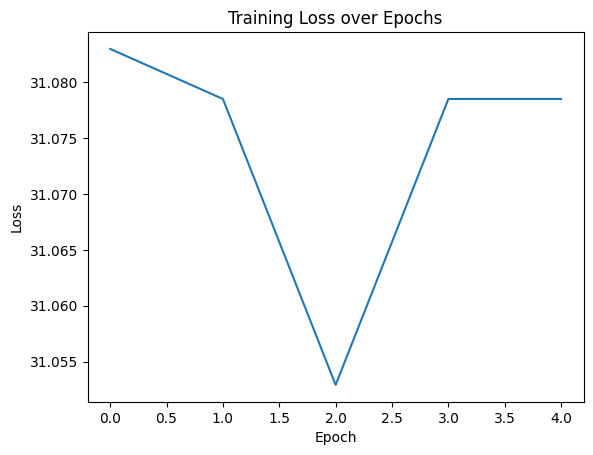

epoch,▁▃▅▆█
train_accuracy,▁▂█▂▂
train_loss,█▇▁▇▇
val_accuracy,█▇▁▇▇
val_loss,▁▂█▂▂
epoch,4
train_accuracy,10.01852
train_loss,31.0785
val_accuracy,9.83333
val_loss,31.14246


wandb: Agent Starting Run: z6bk3jg5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: random


<ipython-input-29-5cfe7f9ee071>:31: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x), axis=0)


Epoch 1, Train_Loss: nan, Train_Accuracy: 18.89%, Val_Loss: nan, Val_Accuracy: 19.38%
Epoch 2, Train_Loss: nan, Train_Accuracy: 10.68%, Val_Loss: nan, Val_Accuracy: 9.63%
Epoch 3, Train_Loss: 2.3579, Train_Accuracy: 10.02%, Val_Loss: 2.3534, Val_Accuracy: 9.83%
Epoch 4, Train_Loss: 2.3161, Train_Accuracy: 10.09%, Val_Loss: 2.3161, Val_Accuracy: 9.17%
Epoch 5, Train_Loss: 2.3093, Train_Accuracy: 10.02%, Val_Loss: 2.3090, Val_Accuracy: 9.83%


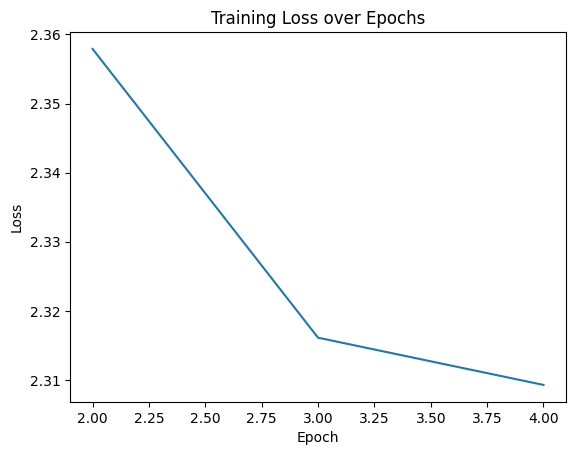

epoch,▁▃▅▆█
train_accuracy,█▂▁▁▁
train_loss,█▂▁
val_accuracy,█▁▁▁▁
val_loss,█▂▁
epoch,4
train_accuracy,10.01852
train_loss,2.30928
val_accuracy,9.83333
val_loss,2.30904


wandb: Agent Starting Run: tj1r96q8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.6006, Train_Accuracy: 79.09%, Val_Loss: 0.6138, Val_Accuracy: 78.10%
Epoch 2, Train_Loss: 0.5539, Train_Accuracy: 81.06%, Val_Loss: 0.5593, Val_Accuracy: 80.47%
Epoch 3, Train_Loss: 0.5446, Train_Accuracy: 80.63%, Val_Loss: 0.5486, Val_Accuracy: 80.08%
Epoch 4, Train_Loss: 0.5352, Train_Accuracy: 81.09%, Val_Loss: 0.5529, Val_Accuracy: 80.47%
Epoch 5, Train_Loss: 0.4859, Train_Accuracy: 82.94%, Val_Loss: 0.4915, Val_Accuracy: 82.53%
Epoch 6, Train_Loss: 0.4536, Train_Accuracy: 83.94%, Val_Loss: 0.4628, Val_Accuracy: 83.40%
Epoch 7, Train_Loss: 0.4299, Train_Accuracy: 84.64%, Val_Loss: 0.4465, Val_Accuracy: 83.75%
Epoch 8, Train_Loss: 0.4226, Train_Accuracy: 84.79%, Val_Loss: 0.4356, Val_Accuracy: 84.22%
Epoch 9, Train_Loss: 0.4405, Train_Accuracy: 84.65%, Val_Loss: 0.4704, Val_Accuracy: 83.85%
Epoch 10, Train_Loss: 0.4413, Train_Accuracy: 84.31%, Val_Loss: 0.4609, Val_Accuracy: 83.83%


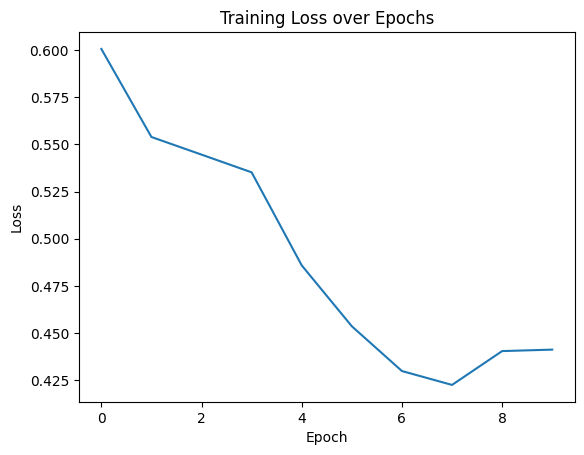

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▃▆▇███▇
train_loss,█▆▆▅▃▂▁▁▂▂
val_accuracy,▁▄▃▄▆▇▇███
val_loss,█▆▅▆▃▂▁▁▂▂
epoch,9
train_accuracy,84.30926
train_loss,0.44128
val_accuracy,83.83333
val_loss,0.4609


wandb: Agent Starting Run: jmsggw8j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum
wandb: 	regularization: 0.5
wandb: 	weight_init: random


Epoch 1, Train_Loss: 31.0900, Train_Accuracy: 9.99%, Val_Loss: 31.0388, Val_Accuracy: 10.13%
Epoch 2, Train_Loss: 31.0971, Train_Accuracy: 9.96%, Val_Loss: 30.9755, Val_Accuracy: 10.32%
Epoch 3, Train_Loss: 31.0766, Train_Accuracy: 10.02%, Val_Loss: 31.1597, Val_Accuracy: 9.78%
Epoch 4, Train_Loss: 31.1022, Train_Accuracy: 9.95%, Val_Loss: 30.9295, Val_Accuracy: 10.45%
Epoch 5, Train_Loss: 31.1022, Train_Accuracy: 9.95%, Val_Loss: 30.9295, Val_Accuracy: 10.45%
Epoch 6, Train_Loss: 31.0830, Train_Accuracy: 10.01%, Val_Loss: 31.1022, Val_Accuracy: 9.95%
Epoch 7, Train_Loss: 31.1022, Train_Accuracy: 9.95%, Val_Loss: 30.9295, Val_Accuracy: 10.45%
Epoch 8, Train_Loss: 31.0971, Train_Accuracy: 9.96%, Val_Loss: 30.9755, Val_Accuracy: 10.32%
Epoch 9, Train_Loss: 31.0830, Train_Accuracy: 10.01%, Val_Loss: 31.1022, Val_Accuracy: 9.95%
Epoch 10, Train_Loss: 31.0983, Train_Accuracy: 9.96%, Val_Loss: 30.9640, Val_Accuracy: 10.35%


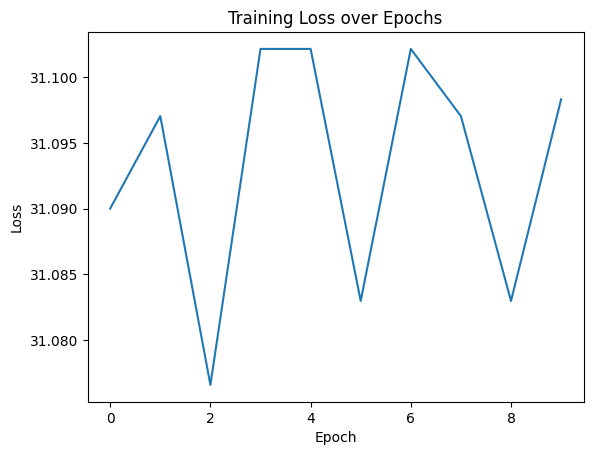

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▂█▁▁▆▁▂▆▂
train_loss,▅▇▁██▃█▇▃▇
val_accuracy,▅▇▁██▃█▇▃▇
val_loss,▄▂█▁▁▆▁▂▆▂
epoch,9
train_accuracy,9.96111
train_loss,31.09833
val_accuracy,10.35
val_loss,30.96401


wandb: Agent Starting Run: 9if43pdw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: 	regularization: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.5299, Train_Accuracy: 81.06%, Val_Loss: 0.5443, Val_Accuracy: 79.87%
Epoch 2, Train_Loss: 0.4436, Train_Accuracy: 83.77%, Val_Loss: 0.4519, Val_Accuracy: 83.27%
Epoch 3, Train_Loss: 0.4221, Train_Accuracy: 84.76%, Val_Loss: 0.4427, Val_Accuracy: 84.08%
Epoch 4, Train_Loss: 0.4293, Train_Accuracy: 84.40%, Val_Loss: 0.4523, Val_Accuracy: 83.38%
Epoch 5, Train_Loss: 0.3989, Train_Accuracy: 85.37%, Val_Loss: 0.4231, Val_Accuracy: 84.48%


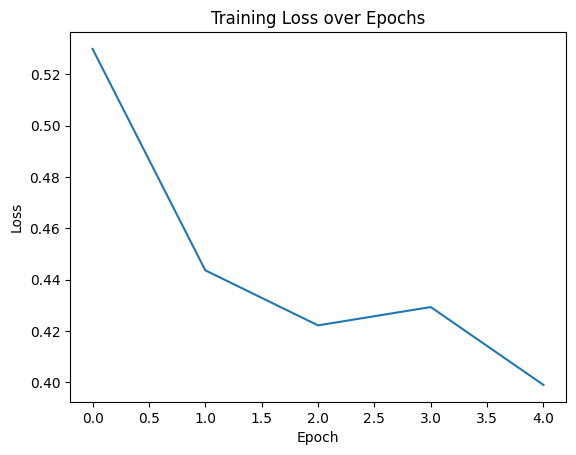

epoch,▁▃▅▆█
train_accuracy,▁▅▇▆█
train_loss,█▃▂▃▁
val_accuracy,▁▆▇▆█
val_loss,█▃▂▃▁
epoch,4
train_accuracy,85.37222
train_loss,0.39894
val_accuracy,84.48333
val_loss,0.42315


In [39]:
def main():
    '''
    WandB calls the main function each time with a different combination of hyperparameters.

    We retrieve these values using `wandb.config` and use them to train the model.
    '''

    with wandb.init() as run:
        # Generate a unique run name based on the hyperparameter values
        run_name = "ac-" + (wandb.config.activation) + \
                   "_nn-" + str(wandb.config.num_neurons) + \
                   "_epc-" + str(wandb.config.epochs) + \
                   "_nl-" + str(wandb.config.num_layers) + \
                   "_reg-" + str(wandb.config.regularization) + \
                   "_lr-" + str(wandb.config.learning_rate) + \
                   "_opt-" + str(wandb.config.optimizer) + \
                   "_bs-" + str(wandb.config.batch_size) + \
                   "_wi-" + str(wandb.config.weight_init)

        # Assign the generated name to the WandB run
        wandb.run.name = run_name

        # Train the model with the current hyperparameter configuration
        train_model(
            wandb.config.learning_rate,  # Learning rate
            X_train, Y_train,            # Training data
            X_valid, Y_valid,            # Validation data
            wandb.config.optimizer,      # Optimizer
            wandb.config.regularization, # Regularization term
            wandb.config.epochs,         # Number of epochs
            wandb.config.activation,     # Activation function
            wandb.config.num_layers,     # Number of hidden layers
            wandb.config.num_neurons,    # Neurons per layer
            wandb.config.weight_init,    # Weight initialization method
            784, 10,                     # Input and output dimensions (Fashion MNIST: 784 input features, 10 classes)
            wandb.config.batch_size,     # Batch size
            epsilon=0.001,                # Small constant for numerical stability
            beta=0.9, beta1=0.9, beta2=0.99  # Hyperparameters for momentum-based optimizers
        )

# Run the sweep agent to execute `main` function multiple times
wandb.agent(sweep_id, function=main, count=6)  # Calls `main` function 6 times with different hyperparameter sets

# Mark the end of the WandB run
wandb.finish()


In [40]:
# Define the hyperparameter sweep configuration
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization for efficient hyperparameter tuning
    'name': 'sweep cross entropy later',  # Name of the sweep for tracking
    'metric': {'name': 'Val_accuracy',  # The metric to optimize
               'goal': 'maximize'},  # The objective is to maximize validation accuracy
    'parameters': {
        'epochs': {'values': [10]},  # Number of training epochs
        'num_layers': {'values': [5]},  # Number of hidden layers
        'num_neurons': {'values': [128]},  # Neurons per layer
        'regularization': {'values': [0]},  # L2 regularization strength
        'learning_rate': {'values': [1e-4]},  # Learning rate values
        'optimizer': {'values': ['rmsprop', 'adam', 'nadam']},  # Optimizers to test
        'batch_size': {'values': [64]},  # Batch sizes for training
        'weight_init': {'values': ['xavier']},  # Weight initialization methods
        'activation': {'values': ['sigmoid', 'relu', 'tanh']}  # Activation functions to test
    }
}

# Initialize the sweep and get the sweep ID
sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_Assignment-1')
# Creates a new sweep in the project 'DA6401_Assignment-1' and returns a sweep ID


Create sweep with ID: j9nerrgq
Sweep URL: https://wandb.ai/ma23m013-iit-madras/DA6401_Assignment-1/sweeps/j9nerrgq


wandb: Agent Starting Run: czxod8xe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.6887, Train_Accuracy: 73.10%, Val_Loss: 0.6921, Val_Accuracy: 72.70%
Epoch 2, Train_Loss: 0.6202, Train_Accuracy: 77.37%, Val_Loss: 0.6335, Val_Accuracy: 76.83%
Epoch 3, Train_Loss: 0.6320, Train_Accuracy: 76.46%, Val_Loss: 0.6433, Val_Accuracy: 75.33%
Epoch 4, Train_Loss: 0.5738, Train_Accuracy: 79.87%, Val_Loss: 0.5946, Val_Accuracy: 79.00%
Epoch 5, Train_Loss: 0.5283, Train_Accuracy: 81.45%, Val_Loss: 0.5386, Val_Accuracy: 80.68%
Epoch 6, Train_Loss: 0.5666, Train_Accuracy: 80.18%, Val_Loss: 0.5830, Val_Accuracy: 79.50%
Epoch 7, Train_Loss: 0.4827, Train_Accuracy: 83.06%, Val_Loss: 0.4969, Val_Accuracy: 82.40%
Epoch 8, Train_Loss: 0.5099, Train_Accuracy: 82.19%, Val_Loss: 0.5421, Val_Accuracy: 81.12%
Epoch 9, Train_Loss: 0.4872, Train_Accuracy: 83.10%, Val_Loss: 0.5225, Val_Accuracy: 82.12%
Epoch 10, Train_Loss: 0.5777, Train_Accuracy: 79.39%, Val_Loss: 0.5987, Val_Accuracy: 78.93%


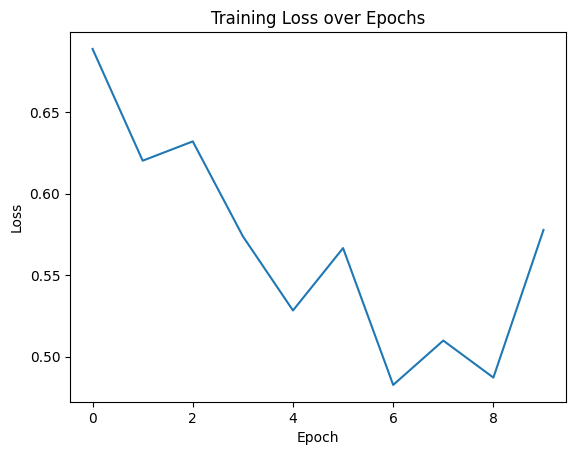

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▃▆▇▆█▇█▅
train_loss,█▆▆▄▃▄▁▂▁▄
val_accuracy,▁▄▃▆▇▆█▇█▅
val_loss,█▆▆▅▂▄▁▃▂▅
epoch,9
train_accuracy,79.38889
train_loss,0.57772
val_accuracy,78.93333
val_loss,0.59873


wandb: Agent Starting Run: 42xffhmv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.4171, Train_Accuracy: 85.00%, Val_Loss: 0.4333, Val_Accuracy: 84.27%
Epoch 2, Train_Loss: 0.3506, Train_Accuracy: 87.28%, Val_Loss: 0.3799, Val_Accuracy: 86.57%
Epoch 3, Train_Loss: 0.3413, Train_Accuracy: 87.45%, Val_Loss: 0.3746, Val_Accuracy: 86.65%
Epoch 4, Train_Loss: 0.3350, Train_Accuracy: 87.53%, Val_Loss: 0.3714, Val_Accuracy: 86.87%
Epoch 5, Train_Loss: 0.3139, Train_Accuracy: 88.46%, Val_Loss: 0.3635, Val_Accuracy: 87.12%
Epoch 6, Train_Loss: 0.3141, Train_Accuracy: 88.48%, Val_Loss: 0.3683, Val_Accuracy: 86.68%
Epoch 7, Train_Loss: 0.3134, Train_Accuracy: 88.66%, Val_Loss: 0.3727, Val_Accuracy: 87.12%
Epoch 8, Train_Loss: 0.3020, Train_Accuracy: 88.63%, Val_Loss: 0.3601, Val_Accuracy: 86.92%
Epoch 9, Train_Loss: 0.2924, Train_Accuracy: 89.58%, Val_Loss: 0.3522, Val_Accuracy: 87.72%
Epoch 10, Train_Loss: 0.2915, Train_Accuracy: 89.48%, Val_Loss: 0.3642, Val_Accuracy: 87.18%


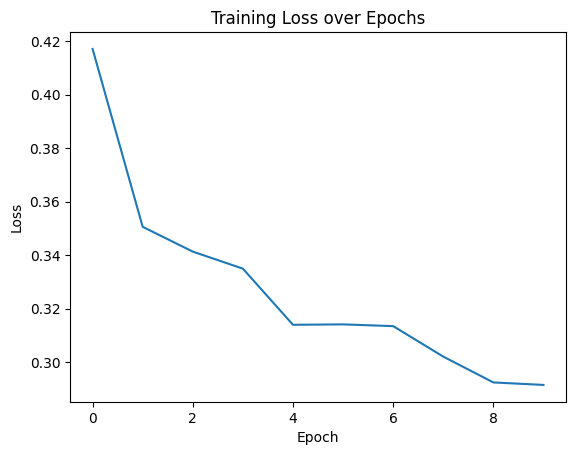

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▄▄▃▂▂▂▂▁▁
val_accuracy,▁▆▆▆▇▆▇▆█▇
val_loss,█▃▃▃▂▂▃▂▁▂
epoch,9
train_accuracy,89.48148
train_loss,0.29146
val_accuracy,87.18333
val_loss,0.36423


wandb: Agent Starting Run: ph64i5md with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.4304, Train_Accuracy: 84.29%, Val_Loss: 0.4502, Val_Accuracy: 83.38%
Epoch 2, Train_Loss: 0.3601, Train_Accuracy: 87.01%, Val_Loss: 0.3893, Val_Accuracy: 86.58%
Epoch 3, Train_Loss: 0.3451, Train_Accuracy: 87.15%, Val_Loss: 0.3801, Val_Accuracy: 86.58%
Epoch 4, Train_Loss: 0.3396, Train_Accuracy: 87.54%, Val_Loss: 0.3727, Val_Accuracy: 86.73%
Epoch 5, Train_Loss: 0.3163, Train_Accuracy: 88.45%, Val_Loss: 0.3723, Val_Accuracy: 86.73%
Epoch 6, Train_Loss: 0.3037, Train_Accuracy: 88.84%, Val_Loss: 0.3558, Val_Accuracy: 87.25%
Epoch 7, Train_Loss: 0.3023, Train_Accuracy: 88.93%, Val_Loss: 0.3537, Val_Accuracy: 87.40%
Epoch 8, Train_Loss: 0.3020, Train_Accuracy: 88.86%, Val_Loss: 0.3677, Val_Accuracy: 86.75%
Epoch 9, Train_Loss: 0.2974, Train_Accuracy: 89.20%, Val_Loss: 0.3617, Val_Accuracy: 87.52%
Epoch 10, Train_Loss: 0.2896, Train_Accuracy: 89.58%, Val_Loss: 0.3443, Val_Accuracy: 88.07%


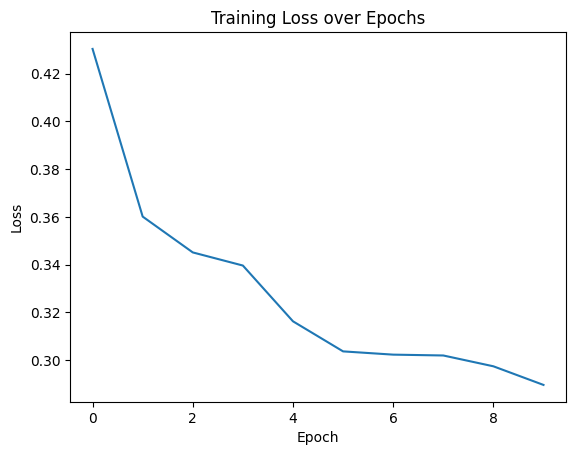

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▅▇▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▆▆▆▆▇▇▆▇█
val_loss,█▄▃▃▃▂▂▃▂▁
epoch,9
train_accuracy,89.57593
train_loss,0.28964
val_accuracy,88.06667
val_loss,0.34427


wandb: Agent Starting Run: jnf5fo8h with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7639, Train_Accuracy: 71.35%, Val_Loss: 0.7714, Val_Accuracy: 71.03%
Epoch 2, Train_Loss: 0.5978, Train_Accuracy: 77.68%, Val_Loss: 0.6099, Val_Accuracy: 76.98%
Epoch 3, Train_Loss: 0.5538, Train_Accuracy: 79.48%, Val_Loss: 0.5756, Val_Accuracy: 78.98%
Epoch 4, Train_Loss: 0.5196, Train_Accuracy: 81.47%, Val_Loss: 0.5364, Val_Accuracy: 81.12%
Epoch 5, Train_Loss: 0.4468, Train_Accuracy: 84.18%, Val_Loss: 0.4803, Val_Accuracy: 83.25%
Epoch 6, Train_Loss: 0.4815, Train_Accuracy: 82.21%, Val_Loss: 0.5048, Val_Accuracy: 81.40%
Epoch 7, Train_Loss: 0.4599, Train_Accuracy: 83.25%, Val_Loss: 0.4818, Val_Accuracy: 82.57%
Epoch 8, Train_Loss: 0.4468, Train_Accuracy: 84.17%, Val_Loss: 0.4694, Val_Accuracy: 83.72%
Epoch 9, Train_Loss: 0.4096, Train_Accuracy: 85.26%, Val_Loss: 0.4395, Val_Accuracy: 84.45%
Epoch 10, Train_Loss: 0.4184, Train_Accuracy: 84.42%, Val_Loss: 0.4475, Val_Accuracy: 83.60%


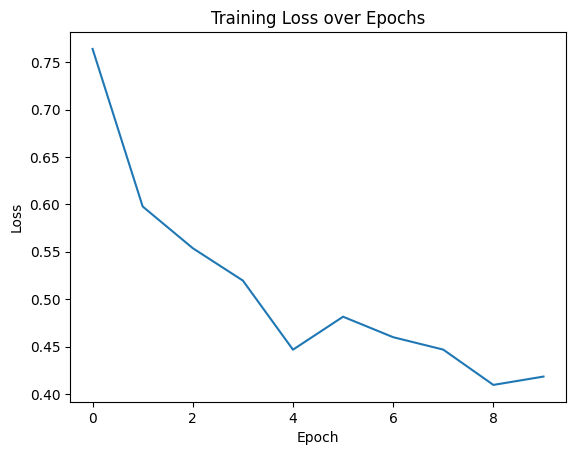

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▆▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▄▅▆▇▆▇███
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,9
train_accuracy,84.42407
train_loss,0.41839
val_accuracy,83.6
val_loss,0.44745


wandb: Agent Starting Run: m21d2jcb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.9167, Train_Accuracy: 67.29%, Val_Loss: 0.9389, Val_Accuracy: 65.70%
Epoch 2, Train_Loss: 0.6539, Train_Accuracy: 75.40%, Val_Loss: 0.6586, Val_Accuracy: 75.25%
Epoch 3, Train_Loss: 0.6115, Train_Accuracy: 78.01%, Val_Loss: 0.6231, Val_Accuracy: 77.60%
Epoch 4, Train_Loss: 0.4855, Train_Accuracy: 82.43%, Val_Loss: 0.5068, Val_Accuracy: 81.45%
Epoch 5, Train_Loss: 0.5237, Train_Accuracy: 81.70%, Val_Loss: 0.5385, Val_Accuracy: 81.13%
Epoch 6, Train_Loss: 0.4817, Train_Accuracy: 83.21%, Val_Loss: 0.5040, Val_Accuracy: 82.08%
Epoch 7, Train_Loss: 0.4794, Train_Accuracy: 83.64%, Val_Loss: 0.4957, Val_Accuracy: 83.02%
Epoch 8, Train_Loss: 0.4178, Train_Accuracy: 84.69%, Val_Loss: 0.4480, Val_Accuracy: 84.07%
Epoch 9, Train_Loss: 0.4450, Train_Accuracy: 83.60%, Val_Loss: 0.4730, Val_Accuracy: 82.50%
Epoch 10, Train_Loss: 0.4317, Train_Accuracy: 84.96%, Val_Loss: 0.4603, Val_Accuracy: 84.48%


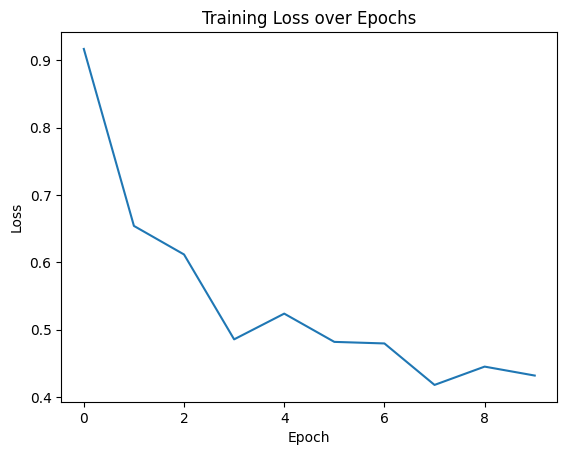

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇▇█▇█
train_loss,█▄▄▂▂▂▂▁▁▁
val_accuracy,▁▅▅▇▇▇▇█▇█
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,9
train_accuracy,84.95741
train_loss,0.43169
val_accuracy,84.48333
val_loss,0.4603


wandb: Agent Starting Run: z34oijzj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7830, Train_Accuracy: 69.88%, Val_Loss: 0.7945, Val_Accuracy: 69.25%
Epoch 2, Train_Loss: 0.7823, Train_Accuracy: 72.39%, Val_Loss: 0.8060, Val_Accuracy: 71.37%
Epoch 3, Train_Loss: 0.6984, Train_Accuracy: 72.83%, Val_Loss: 0.7142, Val_Accuracy: 71.17%
Epoch 4, Train_Loss: 0.6512, Train_Accuracy: 74.61%, Val_Loss: 0.6640, Val_Accuracy: 74.38%
Epoch 5, Train_Loss: 0.5801, Train_Accuracy: 78.93%, Val_Loss: 0.5878, Val_Accuracy: 78.63%
Epoch 6, Train_Loss: 0.6136, Train_Accuracy: 76.91%, Val_Loss: 0.6256, Val_Accuracy: 75.97%
Epoch 7, Train_Loss: 0.6155, Train_Accuracy: 77.66%, Val_Loss: 0.6253, Val_Accuracy: 77.00%
Epoch 8, Train_Loss: 0.5993, Train_Accuracy: 76.61%, Val_Loss: 0.6224, Val_Accuracy: 75.48%
Epoch 9, Train_Loss: 0.5183, Train_Accuracy: 81.26%, Val_Loss: 0.5325, Val_Accuracy: 80.33%
Epoch 10, Train_Loss: 0.5966, Train_Accuracy: 75.85%, Val_Loss: 0.6200, Val_Accuracy: 75.28%


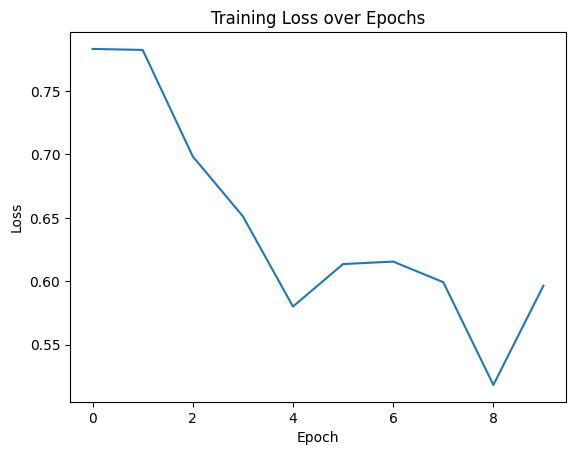

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▇▅▆▅█▅
train_loss,██▆▅▃▄▄▃▁▃
val_accuracy,▁▂▂▄▇▅▆▅█▅
val_loss,██▆▄▂▃▃▃▁▃
epoch,9
train_accuracy,75.8537
train_loss,0.59656
val_accuracy,75.28333
val_loss,0.62


wandb: Agent Starting Run: 7pvzrbk4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 0.7516, Train_Accuracy: 70.36%, Val_Loss: 0.7639, Val_Accuracy: 69.58%
Epoch 2, Train_Loss: 0.7278, Train_Accuracy: 72.64%, Val_Loss: 0.7276, Val_Accuracy: 72.28%
Epoch 3, Train_Loss: 0.6343, Train_Accuracy: 77.15%, Val_Loss: 0.6396, Val_Accuracy: 76.73%
Epoch 4, Train_Loss: 0.6677, Train_Accuracy: 73.61%, Val_Loss: 0.6692, Val_Accuracy: 73.12%
Epoch 5, Train_Loss: 0.5681, Train_Accuracy: 79.82%, Val_Loss: 0.5811, Val_Accuracy: 78.62%
Epoch 6, Train_Loss: 0.6375, Train_Accuracy: 76.69%, Val_Loss: 0.6479, Val_Accuracy: 76.25%
Epoch 7, Train_Loss: 0.5328, Train_Accuracy: 81.69%, Val_Loss: 0.5577, Val_Accuracy: 80.65%
Epoch 8, Train_Loss: 0.5984, Train_Accuracy: 77.23%, Val_Loss: 0.6144, Val_Accuracy: 76.43%
Epoch 9, Train_Loss: 0.4710, Train_Accuracy: 83.46%, Val_Loss: 0.4956, Val_Accuracy: 82.80%
Epoch 10, Train_Loss: 0.4821, Train_Accuracy: 83.44%, Val_Loss: 0.4984, Val_Accuracy: 83.03%


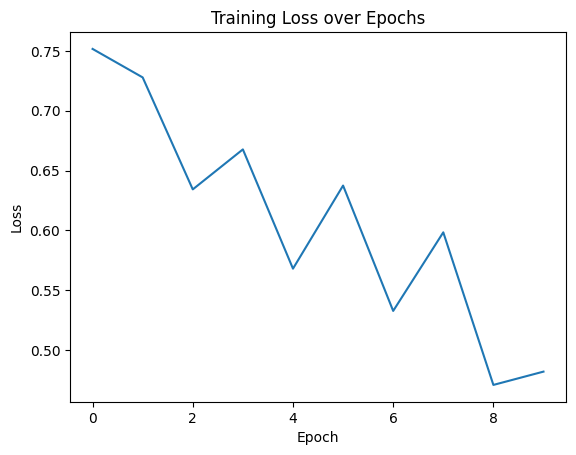

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▃▆▄▇▅██
train_loss,█▇▅▆▃▅▃▄▁▁
val_accuracy,▁▂▅▃▆▄▇▅██
val_loss,█▇▅▆▃▅▃▄▁▁
epoch,9
train_accuracy,83.44444
train_loss,0.48206
val_accuracy,83.03333
val_loss,0.49843


wandb: Agent Starting Run: 55tui3yp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.2405, Train_Accuracy: 51.09%, Val_Loss: 1.2481, Val_Accuracy: 50.22%
Epoch 2, Train_Loss: 0.9577, Train_Accuracy: 57.12%, Val_Loss: 0.9782, Val_Accuracy: 55.60%
Epoch 3, Train_Loss: 0.8226, Train_Accuracy: 63.56%, Val_Loss: 0.8378, Val_Accuracy: 63.28%
Epoch 4, Train_Loss: 0.7672, Train_Accuracy: 69.94%, Val_Loss: 0.7770, Val_Accuracy: 69.50%
Epoch 5, Train_Loss: 0.6704, Train_Accuracy: 74.45%, Val_Loss: 0.6898, Val_Accuracy: 73.57%
Epoch 6, Train_Loss: 0.6967, Train_Accuracy: 73.58%, Val_Loss: 0.7026, Val_Accuracy: 73.88%
Epoch 7, Train_Loss: 0.6333, Train_Accuracy: 77.53%, Val_Loss: 0.6568, Val_Accuracy: 76.67%
Epoch 8, Train_Loss: 0.6421, Train_Accuracy: 75.45%, Val_Loss: 0.6705, Val_Accuracy: 73.67%
Epoch 9, Train_Loss: 0.5957, Train_Accuracy: 75.57%, Val_Loss: 0.6228, Val_Accuracy: 74.50%
Epoch 10, Train_Loss: 0.5230, Train_Accuracy: 81.19%, Val_Loss: 0.5460, Val_Accuracy: 80.18%


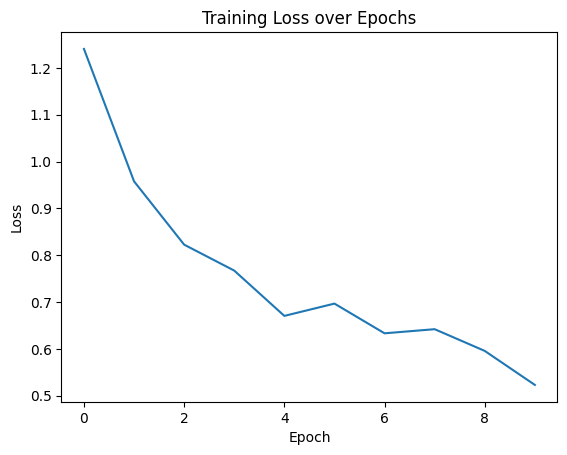

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▆▇▇▇█
train_loss,█▅▄▃▂▃▂▂▂▁
val_accuracy,▁▂▄▆▆▇▇▆▇█
val_loss,█▅▄▃▂▃▂▂▂▁
epoch,9
train_accuracy,81.18704
train_loss,0.52304
val_accuracy,80.18333
val_loss,0.54598


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aip5yg46 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam
wandb: 	regularization: 0
wandb: 	weight_init: xavier


Epoch 1, Train_Loss: 1.4453, Train_Accuracy: 33.86%, Val_Loss: 1.4484, Val_Accuracy: 33.62%
Epoch 2, Train_Loss: 1.2366, Train_Accuracy: 45.60%, Val_Loss: 1.2445, Val_Accuracy: 44.47%
Epoch 3, Train_Loss: 0.9663, Train_Accuracy: 61.34%, Val_Loss: 0.9822, Val_Accuracy: 59.98%
Epoch 4, Train_Loss: 0.9072, Train_Accuracy: 63.39%, Val_Loss: 0.9225, Val_Accuracy: 62.47%
Epoch 5, Train_Loss: 0.8742, Train_Accuracy: 65.57%, Val_Loss: 0.9053, Val_Accuracy: 63.70%
Epoch 6, Train_Loss: 0.7456, Train_Accuracy: 70.39%, Val_Loss: 0.7696, Val_Accuracy: 69.05%
Epoch 7, Train_Loss: 0.6916, Train_Accuracy: 73.55%, Val_Loss: 0.7060, Val_Accuracy: 72.90%
Epoch 8, Train_Loss: 0.6052, Train_Accuracy: 77.46%, Val_Loss: 0.6164, Val_Accuracy: 76.82%
Epoch 9, Train_Loss: 0.6964, Train_Accuracy: 71.78%, Val_Loss: 0.7157, Val_Accuracy: 70.73%
Epoch 10, Train_Loss: 0.5903, Train_Accuracy: 78.98%, Val_Loss: 0.6022, Val_Accuracy: 78.53%


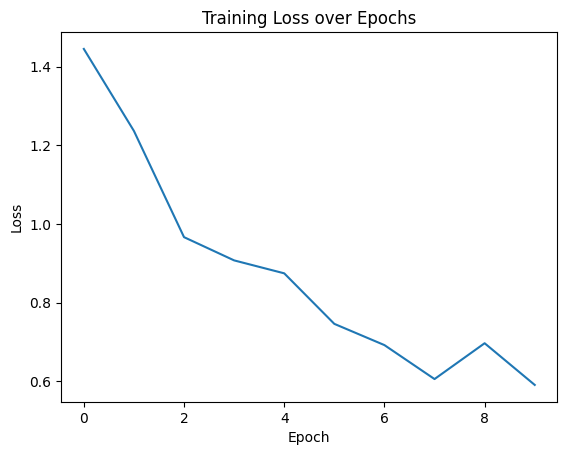

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇█▇█
train_loss,█▆▄▄▃▂▂▁▂▁
val_accuracy,▁▃▅▅▆▇▇█▇█
val_loss,█▆▄▄▄▂▂▁▂▁
epoch,9
train_accuracy,78.97963
train_loss,0.59026
val_accuracy,78.53333
val_loss,0.60219


In [41]:
def main():
    '''
    WandB calls the main function each time with a different combination of hyperparameters.

    We retrieve these values using `wandb.config` and use them to train the model.
    '''

    with wandb.init() as run:
        # Generate a unique run name based on the hyperparameter values
        run_name = "ac-" + (wandb.config.activation) + \
                   "_nn-" + str(wandb.config.num_neurons) + \
                   "_epc-" + str(wandb.config.epochs) + \
                   "_nl-" + str(wandb.config.num_layers) + \
                   "_reg-" + str(wandb.config.regularization) + \
                   "_lr-" + str(wandb.config.learning_rate) + \
                   "_opt-" + str(wandb.config.optimizer) + \
                   "_bs-" + str(wandb.config.batch_size) + \
                   "_wi-" + str(wandb.config.weight_init)

        # Assign the generated name to the WandB run
        wandb.run.name = run_name

        # Train the model with the current hyperparameter configuration
        train_model(
            wandb.config.learning_rate,  # Learning rate
            X_train, Y_train,            # Training data
            X_valid, Y_valid,            # Validation data
            wandb.config.optimizer,      # Optimizer
            wandb.config.regularization, # Regularization term
            wandb.config.epochs,         # Number of epochs
            wandb.config.activation,     # Activation function
            wandb.config.num_layers,     # Number of hidden layers
            wandb.config.num_neurons,    # Neurons per layer
            wandb.config.weight_init,    # Weight initialization method
            784, 10,                     # Input and output dimensions (Fashion MNIST: 784 input features, 10 classes)
            wandb.config.batch_size,     # Batch size
            epsilon=0.001,                # Small constant for numerical stability
            beta=0.9, beta1=0.9, beta2=0.99  # Hyperparameters for momentum-based optimizers
        )

# Run the sweep agent to execute `main` function multiple times
wandb.agent(sweep_id, function=main, count=9)  # Calls `main` function 9 times with different hyperparameter sets

# Mark the end of the WandB run
wandb.finish()
